# How to create and control loops

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>
                <a href="/langgraphjs/concepts/low_level/#graphs">
                    Graphs
                </a>
            </li>
            <li>
                <a href="/langgraphjs/concepts/low_level/#recursion-limit">
                    Recursion Limit
                </a>
            </li>
            <li>
                <a href="/langgraphjs/concepts/low_level/#nodes">
                    Nodes
                </a>
            </li>
        </ul>
    </p>
</div> 


When creating a graph with a loop, we require a mechanism for terminating execution. This is most commonly done by adding a [conditional edge](/langgraphjs/concepts/low_level/#conditional-edges) that routes to the END node once we reach some termination condition.

You can also set the graph recursion limit when invoking or streaming the graph. The recursion limit sets the number of [supersteps](/langgraphjs/concepts/low_level/#graphs) that the graph is allowed to execute before it raises an error. Read more about the concept of recursion limits [here](/langgraphjs/concepts/low_level/#recursion-limit). 

Let's consider a simple graph with a loop to better understand how these mechanisms work.

## Summary

When creating a loop, you can include a conditional edge that specifies a termination condition:

```ts
const route = async function (state: typeof StateAnnotation.State) {
  if (terminationCondition(state)) {
    return "__END__";
  } else {
    return "a";
  }
}

const graph = StateGraph(State)
  .addNode(a)
  .addNode(b)
  .addConditionalEdges("a", route)
  .addEdge("b", "a")
  .compile();
```

To control the recursion limit, specify `"recursionLimit"` in the config. This will raise a `GraphRecursionError`, which you can catch and handle:

```ts
import { GraphRecursionError } from "@langchain/langgraph";

try {
  await graph.invoke(inputs, { recursionLimit: 3 });
} catch (error) {
  if (error instanceof GraphRecursionError) {
    console.log("Recursion Error");
  } else {
    throw error;
  }
}
```

## Setup

First, let's install the required packages

```bash
npm install @langchain/langgraph @langchain/core
```

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Define the graph

Let's define a graph with a simple loop. Note that we use a conditional edge to implement a termination condition.

In [3]:
import { StateGraph, Annotation } from "@langchain/langgraph";

// Define the state with a reducer
const StateAnnotation = Annotation.Root({
  aggregate: Annotation<string[]>({
    reducer: (a, b) => a.concat(b),
    default: () => [],
  }),
});

// Define nodes
const a = async function (state: typeof StateAnnotation.State) {
  console.log(`Node A sees ${state.aggregate}`);
  return { aggregate: ["A"] };
}

const b = async function (state: typeof StateAnnotation.State) {
  console.log(`Node B sees ${state.aggregate}`);
  return { aggregate: ["B"] };
}

// Define edges
const route = async function (state: typeof StateAnnotation.State) {
  if (state.aggregate.length < 7) {
    return "b";
  } else {
    return "__end__";
  }
}


// Define the graph
const graph = new StateGraph(StateAnnotation)
  .addNode("a", a)
  .addNode("b", b)
  .addEdge("__start__", "a")
  .addConditionalEdges("a", route)
  .addEdge("b", "a")
  .compile();

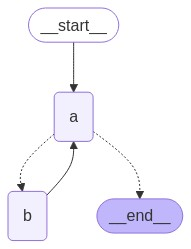

In [4]:
import * as tslab from "tslab";

const drawableGraph = graph.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

This architecture is similar to a [ReAct agent](/langgraphjs/how-tos/#prebuilt-react-agent) in which node `"a"` is a tool-calling model, and node `"b"` represents the tools.

In our `route` conditional edge, we specify that we should end after the `"aggregate"` list in the state passes a threshold length.

Invoking the graph, we see that we alternate between nodes `"a"` and `"b"` before terminating once we reach the termination condition.

In [5]:
await graph.invoke({ aggregate: [] });

Node A sees 
Node B sees A
Node A sees A,B
Node B sees A,B,A
Node A sees A,B,A,B
Node B sees A,B,A,B,A
Node A sees A,B,A,B,A,B
{
  aggregate: [
    'A', 'B', 'A',
    'B', 'A', 'B',
    'A'
  ]
}


## Impose a recursion limit

In some applications, we may not have a guarantee that we will reach a given termination condition. In these cases, we can set the graph's [recursion limit](/langgraphjs/concepts/low_level/#recursion-limit). This will raise a `GraphRecursionError` after a given number of [supersteps](/langgraphjs/concepts/low_level/#graphs). We can then catch and handle this exception:

In [ ]:
import { GraphRecursionError } from "@langchain/langgraph";

try {
  await graph.invoke({ aggregate: [] }, { recursionLimit: 4 });
} catch (error) {
  if (error instanceof GraphRecursionError) {
    console.log("Recursion Error");
  } else {
    throw error;
  }
}

Node A sees 
Node B sees A
Node A sees A,B
Node B sees A,B,A
Recursion Error


Note that this time we terminate after the fourth step.

## Loops with branches

To better understand how the recursion limit works, let's consider a more complex example. Below we implement a loop, but one step fans out into two nodes:

In [7]:
import { StateGraph, Annotation } from "@langchain/langgraph";

// Define the state with a reducer
const StateAnnotationWithLoops = Annotation.Root({
  aggregate: Annotation<string[]>({
    reducer: (a, b) => a.concat(b),
    default: () => [],
  }),
});

// Define nodes
const nodeA = async function (state: typeof StateAnnotationWithLoops.State) {
  console.log(`Node A sees ${state.aggregate}`);
  return { aggregate: ["A"] };
}

const nodeB = async function (state: typeof StateAnnotationWithLoops.State) {
  console.log(`Node B sees ${state.aggregate}`);
  return { aggregate: ["B"] };
}

const nodeC = async function (state: typeof StateAnnotationWithLoops.State) {
  console.log(`Node C sees ${state.aggregate}`);
  return { aggregate: ["C"] };
}

const nodeD = async function (state: typeof StateAnnotationWithLoops.State) {
  console.log(`Node D sees ${state.aggregate}`);
  return { aggregate: ["D"] };
}

// Define edges
const loopRouter = async function (state: typeof StateAnnotationWithLoops.State) {
  if (state.aggregate.length < 7) {
    return "b";
  } else {
    return "__end__";
  }
}

// Define the graph
const graphWithLoops = new StateGraph(StateAnnotationWithLoops)
  .addNode("a", nodeA)
  .addNode("b", nodeB)
  .addNode("c", nodeC)
  .addNode("d", nodeD)
  .addEdge("__start__", "a")
  .addConditionalEdges("a", loopRouter)
  .addEdge("b", "c")
  .addEdge("b", "d")
  .addEdge(["c", "d"], "a")
  .compile();

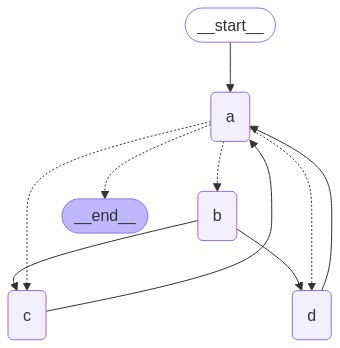

In [8]:
import * as tslab from "tslab";

const drawableGraphWithLoops = graphWithLoops.getGraph();
const imageWithLoops = await drawableGraphWithLoops.drawMermaidPng();
const arrayBufferWithLoops = await imageWithLoops.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBufferWithLoops));

This graph looks complex, but can be conceptualized as loop of [supersteps](../../concepts/low_level/#graphs):

1. Node A
2. Node B
3. Nodes C and D
4. Node A
5. ...

We have a loop of four supersteps, where nodes C and D are executed concurrently.

Invoking the graph as before, we see that we complete two full "laps" before hitting the termination condition:

In [9]:
await graphWithLoops.invoke({ aggregate: [] })

Node A sees 
Node B sees A
Node C sees A,B
Node D sees A,B
Node A sees A,B,C,D
Node B sees A,B,C,D,A
Node C sees A,B,C,D,A,B
Node D sees A,B,C,D,A,B
Node A sees A,B,C,D,A,B,C,D
{
  aggregate: [
    'A', 'B', 'C',
    'D', 'A', 'B',
    'C', 'D', 'A'
  ]
}


However, if we set the recursion limit to four, we only complete one lap because each lap is four supersteps:

In [10]:
import { GraphRecursionError } from "@langchain/langgraph";

try {
  await graphWithLoops.invoke({ aggregate: [] }, { recursionLimit: 4 });
} catch (error) {
  if (error instanceof GraphRecursionError) {
    console.log("Recursion Error");
  } else {
    throw error;
  }
}

Node A sees 
Node B sees A
Node C sees A,B
Node D sees A,B
Node A sees A,B,C,D
Recursion Error
